In [4]:

# 1) Install & authenticate the Kaggle CLI
!pip install -q kaggle

from google.colab import files
# this will pop up a chooser—select your downloaded kaggle.json
files.upload()

# 2) Place your creds in the right spot
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3) Download & unzip the dataset
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images --unzip -p /content/images


Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other


In [ ]:
# Download Packages
!pip install xgboost
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install opencv-python
!pip install glob
!pip install matplotlib
!pip install sklearn
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install pillow
!pip install imutils


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import glob
# import cv2
# import tensorflow
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
# import os
# import seaborn as sns
# from keras.applications.vgg16 import VGG16

Processing training data...

Processing test data...

Training XGBoost model...
[0]	validation_0-logloss:0.56241
[1]	validation_0-logloss:0.54883
[2]	validation_0-logloss:0.53526
[3]	validation_0-logloss:0.52267
[4]	validation_0-logloss:0.51298
[5]	validation_0-logloss:0.50308
[6]	validation_0-logloss:0.49294
[7]	validation_0-logloss:0.48411
[8]	validation_0-logloss:0.47569
[9]	validation_0-logloss:0.46817
[10]	validation_0-logloss:0.46113
[11]	validation_0-logloss:0.45369
[12]	validation_0-logloss:0.44636
[13]	validation_0-logloss:0.43989
[14]	validation_0-logloss:0.43356
[15]	validation_0-logloss:0.42766
[16]	validation_0-logloss:0.42235
[17]	validation_0-logloss:0.41658
[18]	validation_0-logloss:0.41136
[19]	validation_0-logloss:0.40629
[20]	validation_0-logloss:0.40153
[21]	validation_0-logloss:0.39708
[22]	validation_0-logloss:0.39267
[23]	validation_0-logloss:0.38877
[24]	validation_0-logloss:0.38515
[25]	validation_0-logloss:0.38091
[26]	validation_0-logloss:0.37676
[27]	validat

[235]	validation_0-logloss:0.23413
[236]	validation_0-logloss:0.23422
[237]	validation_0-logloss:0.23405
[238]	validation_0-logloss:0.23395
[239]	validation_0-logloss:0.23358
[240]	validation_0-logloss:0.23342
[241]	validation_0-logloss:0.23341
[242]	validation_0-logloss:0.23343
[243]	validation_0-logloss:0.23334
[244]	validation_0-logloss:0.23305
[245]	validation_0-logloss:0.23285
[246]	validation_0-logloss:0.23295
[247]	validation_0-logloss:0.23253
[248]	validation_0-logloss:0.23200
[249]	validation_0-logloss:0.23204
[250]	validation_0-logloss:0.23183
[251]	validation_0-logloss:0.23174
[252]	validation_0-logloss:0.23171
[253]	validation_0-logloss:0.23189
[254]	validation_0-logloss:0.23157
[255]	validation_0-logloss:0.23167
[256]	validation_0-logloss:0.23173
[257]	validation_0-logloss:0.23174
[258]	validation_0-logloss:0.23136
[259]	validation_0-logloss:0.23146
[260]	validation_0-logloss:0.23122
[261]	validation_0-logloss:0.23115
[262]	validation_0-logloss:0.23097
[263]	validation_0-l

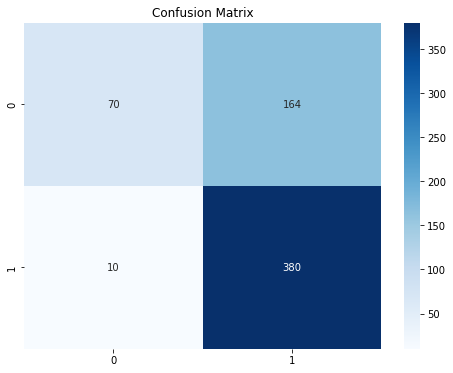


Models saved successfully!


In [3]:
# Import libraries
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xgboost as xgb
import joblib

# Set up matplotlib
%matplotlib inline

#---------------------------------------------------------------
# Enhanced Configuration
#---------------------------------------------------------------
BASE_DIR = "./dataset/chest_xray"
SIZE = 300
BATCH_SIZE = 16
FEATURE_BATCH_SIZE = 64
SEED = 42

#---------------------------------------------------------------
# Advanced Data Augmentation
#---------------------------------------------------------------
train_datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced from 15
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

#---------------------------------------------------------------
# Memory Optimization
#---------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

#---------------------------------------------------------------
# Enhanced Data Processing
#---------------------------------------------------------------
def process_dataset(directory, encoder, feature_extractor, augment=False):
    features = []
    labels = []
    
    for class_dir in glob.glob(os.path.join(directory, "*")):
        label = os.path.basename(class_dir)
        paths = glob.glob(os.path.join(class_dir, "*.jpg")) + \
                glob.glob(os.path.join(class_dir, "*.jpeg"))
        
        for i in range(0, len(paths), BATCH_SIZE):
            batch_images = []
            batch_paths = paths[i:i+BATCH_SIZE]
            
            for path in batch_paths:
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                if augment:
                    img = train_datagen.random_transform(img)
                
                batch_images.append(img.astype(np.float32)/255.0)
            
            if batch_images:
                batch_features = feature_extractor.predict(np.array(batch_images), verbose=0)
                features.append(batch_features)
                labels.extend([label] * len(batch_images))
                
                del batch_images, batch_features
                tf.keras.backend.clear_session()
                
            if len(features) >= FEATURE_BATCH_SIZE:
                yield np.vstack(features), encoder.transform(labels)
                features.clear()
                labels.clear()
    
    if len(features) > 0:
        yield np.vstack(features), encoder.transform(labels)

#---------------------------------------------------------------
# Optimized Main Execution
#---------------------------------------------------------------
def main():
    # Initialize label encoder
    le = preprocessing.LabelEncoder()
    le.fit(["NORMAL", "PNEUMONIA"])
    
    # Verify dataset
    train_dir = os.path.join(BASE_DIR, "train")
    test_dir = os.path.join(BASE_DIR, "test")
    for d in [train_dir, test_dir]:
        if not os.path.exists(d):
            raise FileNotFoundError(f"Directory not found: {d}")

    # Create enhanced feature extractor
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(SIZE, SIZE, 3)
    )
    x = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=x)
    
    # Process training data with augmentation
    print("Processing training data...")
    train_features, train_labels = [], []
    for features, labels in process_dataset(train_dir, le, feature_extractor, augment=True):
        train_features.append(features)
        train_labels.append(labels)
    train_features = np.vstack(train_features)
    train_labels = np.concatenate(train_labels)
    
    # Process test data
    print("\nProcessing test data...")
    test_features, test_labels = [], []
    for features, labels in process_dataset(test_dir, le, feature_extractor):
        test_features.append(features)
        test_labels.append(labels)
    test_features = np.vstack(test_features)
    test_labels = np.concatenate(test_labels)
    
    # Create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        train_features, train_labels,
        test_size=0.15,  # Reduced from 0.2
        stratify=train_labels,
        random_state=SEED
    )
    
    # Enhanced class weighting
    class_counts = np.bincount(y_train)
    scale_pos_weight = np.sqrt(class_counts[1]/class_counts[0])  # Inverted ratio
    
    # Optimized XGBoost parameters
    print("\nTraining XGBoost model...")
    model = xgb.XGBClassifier(
        tree_method='hist',
        device='cuda' if gpus else 'cpu',
        scale_pos_weight=scale_pos_weight,
        n_estimators=300,  # Reduced from 500
        learning_rate=0.03,  # Adjusted from 0.05
        max_depth=5,  # Reduced from 7
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.2,
        reg_lambda=0.2,
        eval_metric='logloss',
        early_stopping_rounds=15
    )
    
    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )
    
    # Optimal threshold selection using accuracy
    val_probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.2, 0.8, 61)
    accuracies = [accuracy_score(y_val, (val_probs >= t).astype(int)) for t in thresholds]
    best_thresh = thresholds[np.argmax(accuracies)]
    
    # Apply optimal threshold to test data
    test_probs = model.predict_proba(test_features)[:, 1]
    predictions = (test_probs >= best_thresh).astype(int)
    
    # Evaluate
    print(f"\nOptimal Threshold: {best_thresh:.2f}")
    print("Test Accuracy:", accuracy_score(test_labels, predictions))
    
    # Confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(le.inverse_transform(test_labels), 
                le.inverse_transform(predictions)),
                annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    # Save models
    os.makedirs("./model", exist_ok=True)
    joblib.dump(model, "./model/xgb_pneumonia.pkl")
    joblib.dump(le, "./model/label_encoder.pkl")
    print("\nModels saved successfully!")
    
    return model, le

if __name__ == "__main__":
    trained_model, label_encoder = main()

In [ ]:
    # Save models
    joblib.dump(trained_model, "./model/xgb_pneumonia.pkl")
    joblib.dump(label_encoder, "./model/label_encoder.pkl")
    print("\nModels saved successfully!")